# Plotting

---

Julia has several high quality registered plotting packages:

* [Winston.jl](https://github.com/nolta/Winston.jl) - simple but efficient 2D plots 
* [Gadfly.jl](https://github.com/dcjones/Gadfly.jl) - versatile 2D package with nice output
* [PyPlot.jl](https://github.com/stevengj/PyPlot.jl) - Julia interface to Python's Matplotlib - 2D, 3D, implicit, ...
* [Plots.jl](https://github.com/stevengj/PyPlot.jl) - wrapper for several backends.

## Prerequisites

Browse the manuals (20 min):

* [Winston Documentation](http://winston.readthedocs.org/en/latest/)
* [Gadfly](http://dcjones.github.io/Gadfly.jl/)
* [The PyPlot module for Julia](https://github.com/stevengj/PyPlot.jl) and [Matplotlib](http://matplotlib.org/)
* [Intro to Plots in Julia](http://plots.readthedocs.org/en/latest/)


## Competences 

The reader should be able to use some of the features of the above packages. 

---

### Remark

Plotting packages are rather complex and depend on additional software, so it is advised to execute corresponding 
`Pkg.add()` commands in terminal mode.  

Also, plotting packges frequently use same (obvious) names for plot functions. When using more than one package in a Julia session, the functions need to be called by specifying the package, as well.

We shall ilustrate the packages on several numerical examples, which also give the flavor of Julia.

## Winston

We compute and plot:
* the natural cubic spline, as defined in [W. Cheney  and D. Kincaid, Numerical Mathematics and Computing, pp. 266-267][CK13], and 
* the standard interpolating polynomial. 

We shall use the registered package [SpecialMatrices.jl](https://github.com/jiahao/SpecialMatrices.jl).

[CK13]: https://books.google.hr/books?id=tDyYdqyZjSEC&pg=PA279&lpg=PA279&dq=kincaid+cheney+cubic+spline&source=bl&ots=3Y0f5tvQku&sig=fezZGlnQ7pR4E67TVkXEq_lF1Zc&hl=hr&sa=X&ved=0ahUKEwju8KGo7YjMAhXLVSwKHXyUAXEQ6AEIRzAG#v=onepage&q=kincaid%20cheney%20cubic%20spline&f=false "W. Cheney  and D. Kincaid, 'Numerical Mathematics and Computing', 7th Edition, Brooks/Cole, Boston, 2013"

In [2]:
# Pkg.add("SpecialMatrices")
using Winston
using SpecialMatrices
using Polynomials

In [3]:
# Number of intervals
n=5
# n+1 points
t=[1.0,2,4,5,8,9]
y=[-1.0,1,4,0,2,6]
# Computation
h=t[2:end]-t[1:end-1]
b=(y[2:end]-y[1:end-1])./h
v=6*(b[2:end]-b[1:end-1])
H=SymTridiagonal(2*(h[1:end-1]+h[2:end]),h[2:end-1])

4x4 SymTridiagonal{Float64}:
 6.0  2.0  0.0  0.0
 2.0  6.0  1.0  0.0
 0.0  1.0  8.0  3.0
 0.0  0.0  3.0  8.0

In [4]:
z=H\v
z=[0;z;0]

6-element Array{Float64,1}:
  0.0    
  1.74766
 -6.74299
  3.96262
  1.01402
  0.0    

In [5]:
# Define the splines
B=b-(z[2:end]-z[1:end-1]).*h/6
S=Array(Any,n)
S=[x-> y[i]-z[i]*h[i]^2/6+B[i]*(x-t[i])+z[i]*(t[i+1]-x)^3/
    (6*h[i])+z[i+1]*(x-t[i])^3/(6*h[i]) for i=1:n]

5-element Array{Function,1}:
 (anonymous function)
 (anonymous function)
 (anonymous function)
 (anonymous function)
 (anonymous function)

In [6]:
# Define the points to plot
lsize=200
x=linspace(t[1],t[end],lsize)
zSpline=Array(Float64,lsize)
for i=1:lsize
    for k=1:n
        if x[i]<=t[k+1]
            zSpline[i]=S[k](x[i])
            break
        end
    end
end

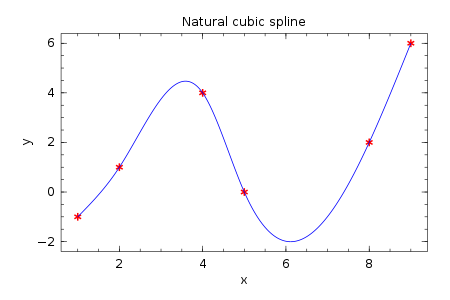

In [7]:
# Plot
Winston.plot(t,y,"r*",x,zSpline,"b")
Winston.title("Natural cubic spline")
xlabel("x")
ylabel("y")

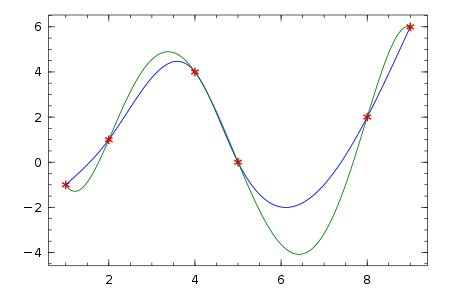

In [8]:
# Standard interpolating polynomial
A=Vandermonde(t)
p=Poly(full(A)\y)
yPoly=p(x)
Winston.plot(t,y,"r*",x,zSpline,"b",x,yPoly,"g")

## Gadfly

We shall illustrate Gadfly with two examples:
* function and its derivative, and
* exact solution of an initial value problem v.s. the solution computed with our implementation of the Euler's method.

N.B. Gadfly plots can be nicely zoomed in or out. Variety of ODE solvers can be found in the package  [ODE.jl](https://github.com/JuliaLang/ODE.jl)

### Function and its derivative

Derivative of a function can be:
* approximated by finite differences using the package [Calculus.jl](https://github.com/johnmyleswhite/Calculus.jl),
* approximated by [automatic differentiation
(https://en.wikipedia.org/wiki/Automatic_differentiation) using the package
[ForwardDiff.jl](https://github.com/JuliaDiff/ForwardDiff.jl) which is fast, 
more accurate, and is our method of choice (see the [Documentation](http://www.juliadiff.org/ForwardDiff.jl/perf_diff.html#derivatives)), and 
* computed symbolicaly using the package [SymPy.jl](https://github.com/jverzani/SymPy.jl).

In [9]:
# Pkg.add("ForwardDiff")
using ForwardDiff
using Gadfly

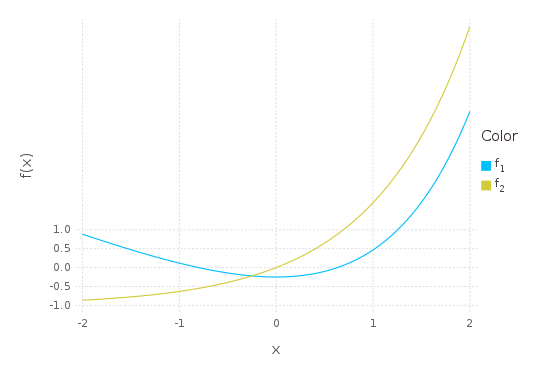

In [10]:
f(x)=exp(x)-x-5.0/4
Gadfly.plot([f,derivative(f)],-2.0,2.0,Guide.yticks(ticks=[-1.0,-0.5,0.0,0.5,1.0]))

### Solution of an  initial value problem

The exact solution of the initial value problem 
$$
y'=x+y,\quad y(0)=1,
$$

is

$$
y=2e^x-x-1.
$$


In [11]:
# Euler's method
function myEuler{T,T1}(f::Function,y0::T,x::T1)
    h=x[2]-x[1]
    y=Array(T,length(x))
    y[1]=y0
    for i=2:length(x)
        y[i]=y[i-1]+h*f(x[i-1],y[i-1])
    end
    y
end

myEuler (generic function with 1 method)

In [12]:
# n subintervals on the interval [0,1]
n=30
x=linspace(0,1,n+1)
f1(x,y)=x+y
y=myEuler(f1,1.0,x)

31-element Array{Float64,1}:
 1.0    
 1.03333
 1.06889
 1.10674
 1.14697
 1.18964
 1.23485
 1.28268
 1.33321
 1.38654
 1.44276
 1.50197
 1.56425
 ⋮      
 2.09572
 2.18669
 2.2818 
 2.38119
 2.48501
 2.5934 
 2.70651
 2.82451
 2.94755
 3.0758 
 3.20943
 3.34864

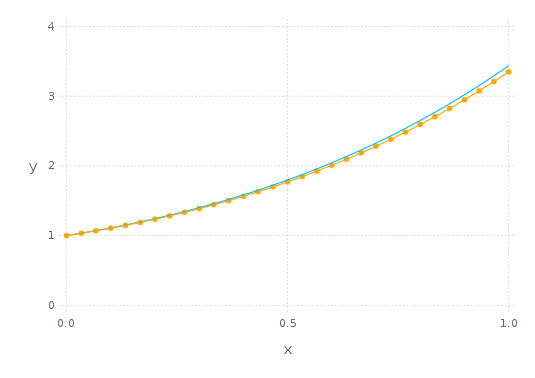

In [13]:
# We can plot functions and data sets (points) using layers
solution(x)=2*exp(x)-x-1
Gadfly.plot(layer(solution,0,1),
layer(x=x,y=y,Geom.point, Geom.line, Theme(default_color=colorant"orange")))

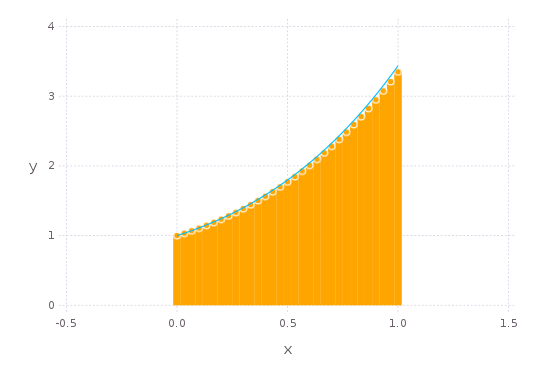

In [14]:
# Or, with a different geometry
Gadfly.plot(layer(solution,0,1),
layer(x=x,y=y,Geom.point, Geom.bar, Theme(default_color=colorant"orange")))

## PyPlot

We shall illustrate PyPlot with two examples:
* 3D and contour plots to graphically solve small system of non-linear equations, and
* implicit plot of the solution of Lotka-Volterra equations in the phase-space. 

### System of non-linear equations

The solutions of the system

\begin{align*}
2(x_1+x_2)^2-(x_1-x_2)^2&=8\\
5x_1^2+(x_2-3)^2&=9
\end{align*}

are

\begin{align*}
S_1&=(-1.183467003241957,1.5868371427229244),\\ S_2&=(1,1).
\end{align*}

Let us plot the surfaces:

In [15]:
using PyPlot

In [16]:
# Define the system
x=Vector{Float64}
f(x)=[2(x[1]+x[2])^2+(x[1]-x[2])^2-8,5*x[1]^2+(x[2]-3)^2-9]

f (generic function with 1 method)

In [17]:
# Prepare the meshgrid manually
gridsize=101
X=linspace(-2,3,gridsize)
Y=linspace(-2,2,gridsize)
gridX= map(Float64,[x for x in X, y in Y])
gridY= map(Float64,[y for x in X, y in Y])
# gridX,gridX=meshgrid(X,Y)
Z1=[f([gridX[i,j],gridY[i,j]])[1] for i=1:gridsize, j=1:gridsize]
Z2=[f([gridX[i,j],gridY[i,j]])[2] for i=1:gridsize, j=1:gridsize]

101x101 Array{Any,2}:
 36.0     35.6016  35.2064  34.8144  …  12.2544  12.1664  12.0816  12.0   
 35.0125  34.6141  34.2189  33.8269     11.2669  11.1789  11.0941  11.0125
 34.05    33.6516  33.2564  32.8644     10.3044  10.2164  10.1316  10.05  
 33.1125  32.7141  32.3189  31.9269      9.3669   9.2789   9.1941   9.1125
 32.2     31.8016  31.4064  31.0144      8.4544   8.3664   8.2816   8.2   
 31.3125  30.9141  30.5189  30.1269  …   7.5669   7.4789   7.3941   7.3125
 30.45    30.0516  29.6564  29.2644      6.7044   6.6164   6.5316   6.45  
 29.6125  29.2141  28.8189  28.4269      5.8669   5.7789   5.6941   5.6125
 28.8     28.4016  28.0064  27.6144      5.0544   4.9664   4.8816   4.8   
 28.0125  27.6141  27.2189  26.8269      4.2669   4.1789   4.0941   4.0125
 27.25    26.8516  26.4564  26.0644  …   3.5044   3.4164   3.3316   3.25  
 26.5125  26.1141  25.7189  25.3269      2.7669   2.6789   2.5941   2.5125
 25.8     25.4016  25.0064  24.6144      2.0544   1.9664   1.8816   1.8   
  ⋮

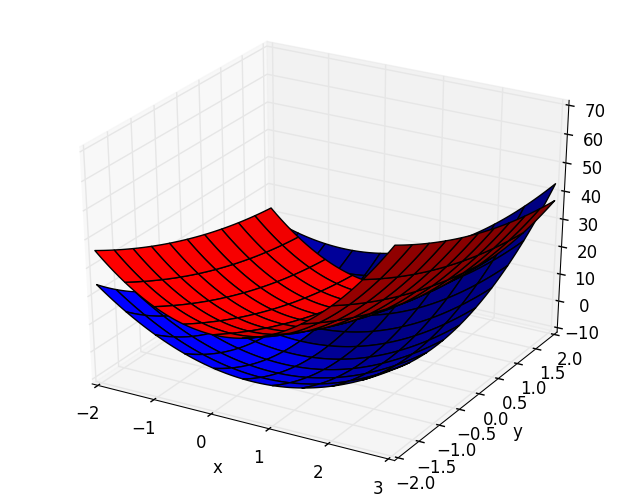

PyObject <matplotlib.text.Text object at 0x7fb7184fe0b8>

In [18]:
# Plot
PyPlot.surf(gridX,gridY,Z1)
PyPlot.surf(gridX,gridY,Z2,color="red")
PyPlot.xlabel("x")
PyPlot.ylabel("y")

Let us plot the contours at $z=0$:

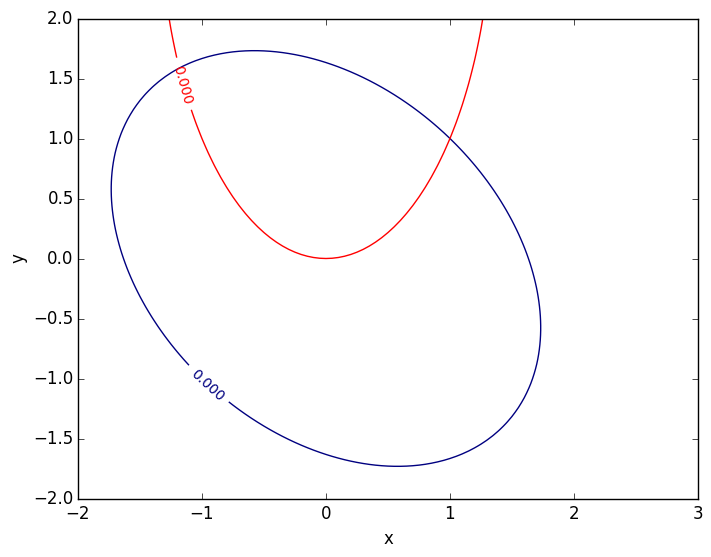

PyObject <matplotlib.text.Text object at 0x7fb717a6b438>

In [19]:
C1=contour(gridX,gridY,Z1,levels=[0])
C2=contour(gridX,gridY,Z2,levels=[0],colors="red")
clabel(C1,inline=1, fontsize=10)
clabel(C2,inline=1, fontsize=10)
PyPlot.xlabel("x")
PyPlot.ylabel("y")

### Plotting implicit functions

The phase-space solution of the Lotka-Volterra system of equations in dimensionless variables in scaled time 
has the form 

$$
yx^\sigma=Ce^ye^{x\sigma}.
$$

For implicit plots, we also need the package `SymPy.jl`. Plotting takes a little longer.

In [21]:
using SymPy

In [22]:
# Define the parameters
C=0.25
σ=1/3
# Define symbolic variables
@vars x,y

(x,y)

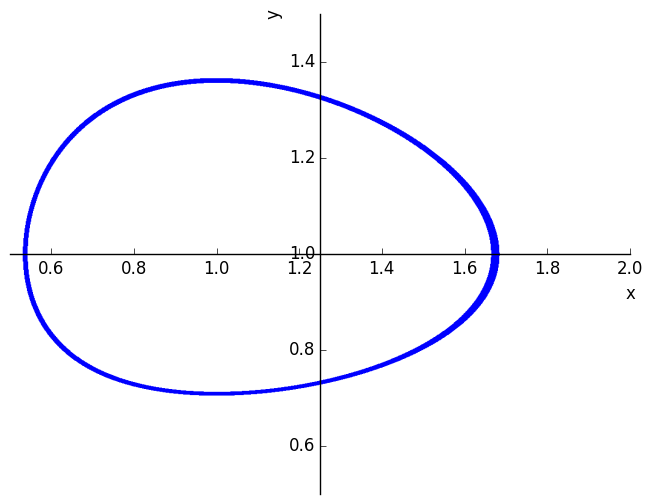

PyObject <sympy.plotting.plot.Plot object at 0x7fb71791df60>

In [23]:
SymPy.plot_implicit(Eq(y*x^σ,C*exp(y+σ*x)),(x,0.5,2),(y,0.5,1.5))